In [111]:
## Generate data series
import numpy as np
import scipy as sp
import sklearn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as stm
import statsmodels.formula.api as smf
import statsmodels.distributions.empirical_distribution
import scipy.stats as stats

np.random.seed(1234567)
stochastic_baseline = np.random.normal (0, 0.5, 1440)
failure_stochastic = np.random.exponential(0.01, 1440)

Data Generation

In [112]:
mydata1 = np.random.gamma(6.0, 0.05, 1440)
mydata2 = np.random.gamma(5.0, 0.05, 1440)
mydata3 = np.random.gamma(1.1, 0.05, 1440)
mydata4 = np.random.gamma(1.1, 0.03, 1440)
pt_num = range(len(mydata1))
mydf = pd.DataFrame({'pt_num': pt_num, 
                     'svc1': mydata1, 
                     'svc2': mydata2,
                     'svc3': mydata3,
                     'svc4': mydata4
                    })
def plot_ts(mydf, svc_pattern = 'svc'):
    svcs = [col for col in mydf.columns if svc_pattern in col]
    fig, ax = plt.subplots(figsize=(11,8.5))
    mydf[svcs].plot(ax = ax)
    ax.set_title('Total Response Times for 4 services', fontsize=18)
    ax.set_ylabel('Response Time [seconds]', fontsize=16)
    plt.show()
    
def plot_kdes(mydf, svc_pattern = 'svc', xlims = (0, 1)):
    svcs = [col for col in mydf.columns if svc_pattern in col]
    fig, ax = plt.subplots(figsize=(11,8.5))
    if xlims is not None:
        mydf[svcs].plot.kde(ax = ax, xlim = xlims)
    else:
        mydf[svcs].plot.kde(ax = ax)

    ax.set_title('Response Time Distribution', fontsize=18)
    ax.set_xlabel('Response Time [sec]', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)

    plt.show()

## Scenario 4: 

Services svc1-svc4 are funneling into one interface, and we want to make sure that faster services are not waiting for the slower ones.  Due to resource constraints, we cannot allocate more than 2 instances of the interface.  So we need to cluster the services into two groups (queues).

We start by exploring the data as time series

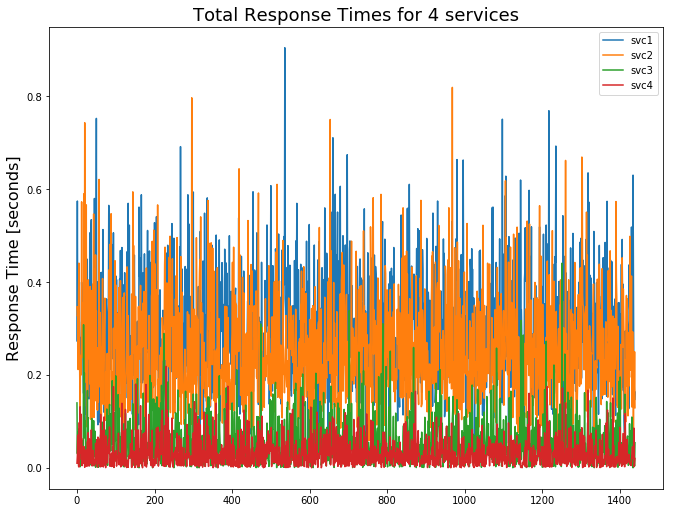

In [113]:
plot_ts(mydf)

A time-series plot is not very clear, especially for colorblind people.  Let's build the PDFs (see Example 1 for details):

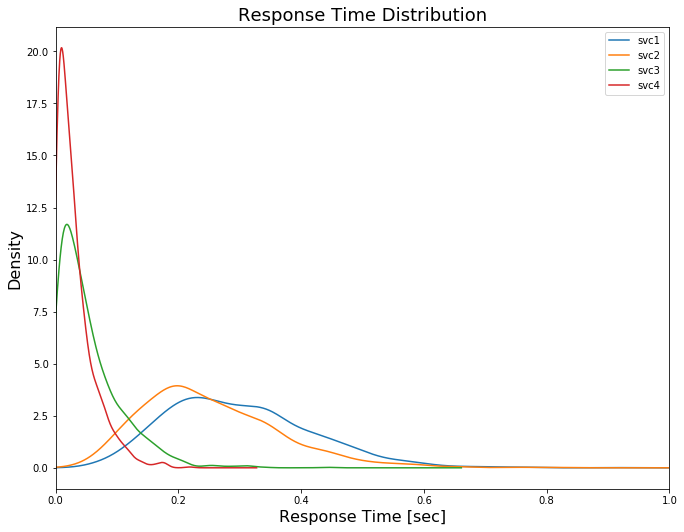

In [114]:
plot_kdes(mydf)

Now we see that 

(1) the distributions have long right tails (are right skewed).  This typically happens with response times: they are usually very right-skewed.  The skew typically is not as pronounced when we are dealing with multiple delays in the service: e.g., Round-Trip Times (RTTs) on a network can be approximated with a Gamma distribution, whereas with servers we typically assume Exponental distribution of response times (M/M/1 queueing).  

(2) there are at least 2 distinct groupings of data: we can count them by, e.g., finding distinct local maxima of the data.  To do that, we will combine the wide table into a long form by using Pandas melt function:

In [115]:
svcs = [col for col in mydf.columns if 'svc' in col]
mydfLong = mydf.melt(id_vars=['pt_num'], var_name='service', value_name='resp_time')
mydfLong.head()

,pt_num,service,resp_time
0,0,svc1,0.273334
1,1,svc1,0.574465
2,2,svc1,0.257138
3,3,svc1,0.322904
4,4,svc1,0.379826


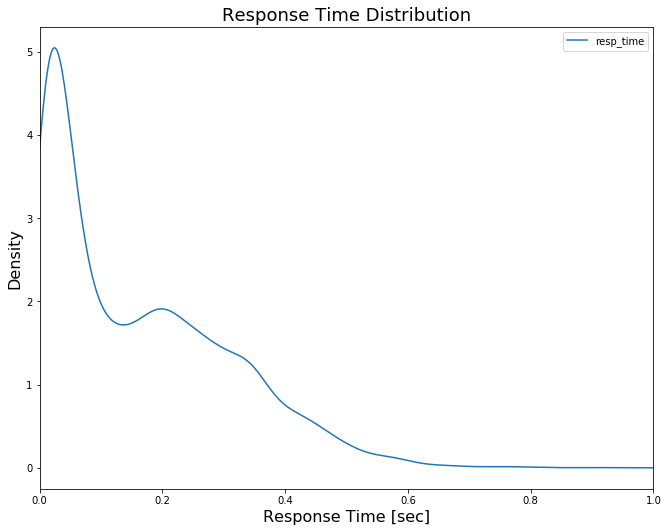

In [116]:
plot_kdes(mydfLong, svc_pattern='resp_time')

We see that there are two local maxima in the overall PDF plot: one near 50 msec and the other one near 200 msec. The minor bump at about 350 msec can be ignored.   

### Two routes from here:
(a) Apply a standard off-the-shelf clustering algorithm

    * k-means
    * GMM-based
    * DBSCAN

(b) Identify the $\textbf{local maxima}$, and then perform $\textbf{pairwise T-test}$ to see which services have the same (statistically indistinguishable) local maxima.

Both paths have one **downside**: they assume a **normal (or at least symmetrical) distribution** of the data around the mean, but we are dealing with skewed distributions.  One way to deal with it is to perform a transformation on the data to reduce the skew.

### Logarithmic Transformation:

If we apply log-transform: 

$$ Y' = ln (Y), $$

or since $ Y_i < 0, \forall i, $

$$ Y' = ln (1.0 + Y) $$

we will significantly change the distribution, making it more symmetrical:

In [117]:
def plot_svcs_kdes (mydfLong, what2plot):
    mydfLong.sort_values(what2plot)
    svcs = list(set(mydfLong['service']))
    plt.figure(figsize = (11, 8.5))
    svcs.sort()
    for ii in range(len(svcs)):
        plt.subplot(2, 2, ii+1)

        subset = mydfLong[mydfLong['service'] == svcs[ii]]
        subset[what2plot].plot.kde(title = svcs[ii])

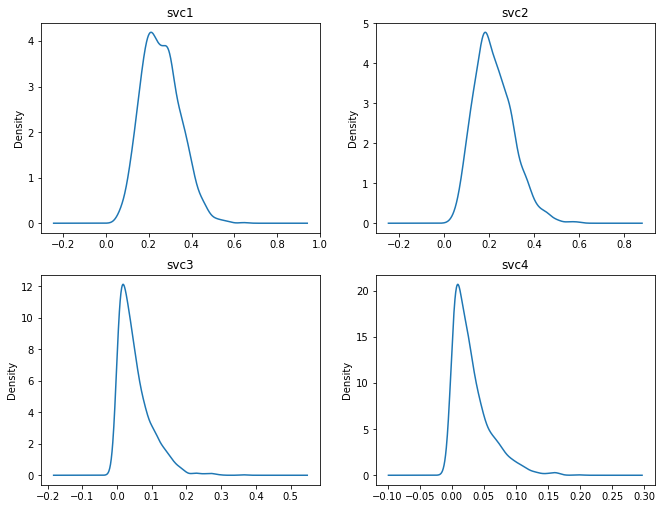

In [118]:
mydfLong['log_rt'] = np.log(1.0 + mydfLong['resp_time'])
plot_svcs_kdes(mydfLong, 'log_rt')

An alternative way to make the distributions more symmetrical (closer to Gaussian) is the ***Box-Cox transformation***,  where we change the variable using a parameter $\lambda \in (0...1)$, until we have a confirmation by a statistical test (*Anderson-Darling Test*) that the distribution is Gaussian.   The new variable has the form of:

$$ Y' = \frac{Y^\lambda - 1}{\lambda}, $$

where $\lambda \in (0...1).$  The log-transformation has been included *by fiat* as a special case for $\lambda = 0.$


In [119]:
def plot_pre_post_bctransform (x, xt, svc):

    ## Plot quantiles for raw data, compare with normal
    fig = plt.figure(figsize = (11, 8.5))
    ax1 = fig.add_subplot(211 )
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title(svc + ' Probplot against normal distribution')

    ## Plot quantiles for transformed data, compare with normal
    ax2 = fig.add_subplot(212)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title(svc + ' Probplot after Box-Cox transformation')



For svc1, got Box-Cox lambda = 0.389
For svc2, got Box-Cox lambda = 0.284
For svc3, got Box-Cox lambda = 0.292
For svc4, got Box-Cox lambda = 0.256


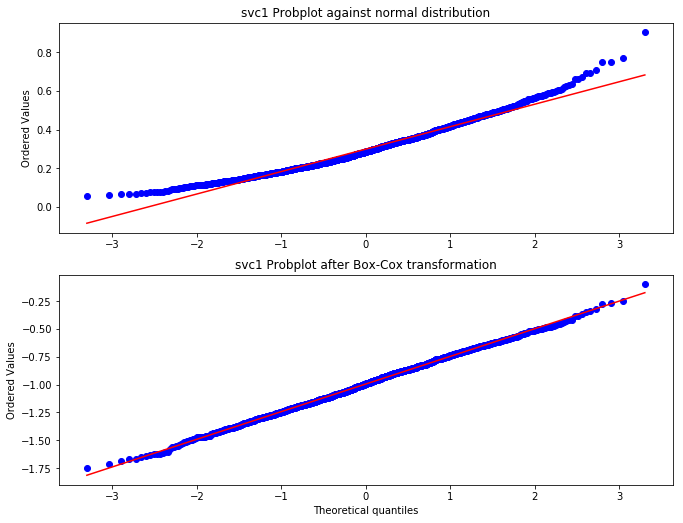

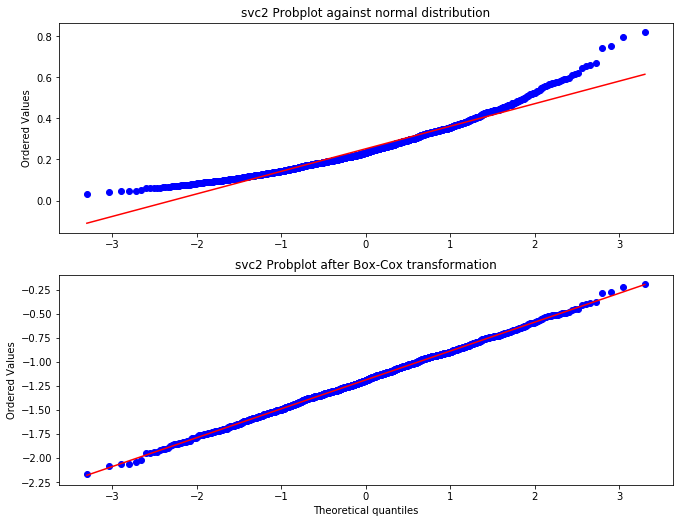

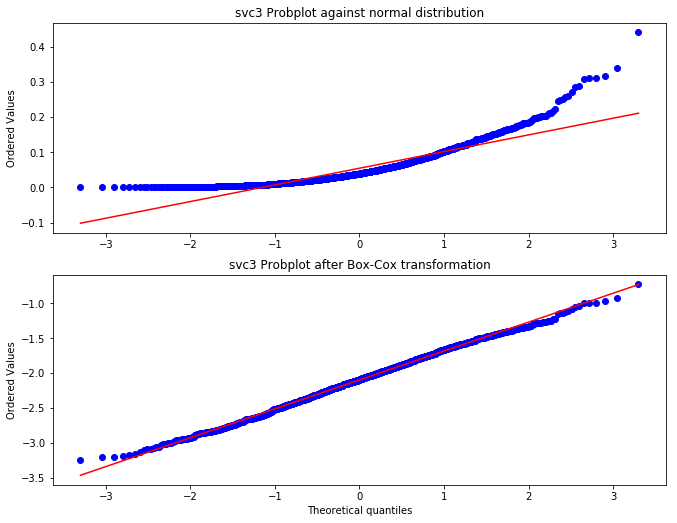

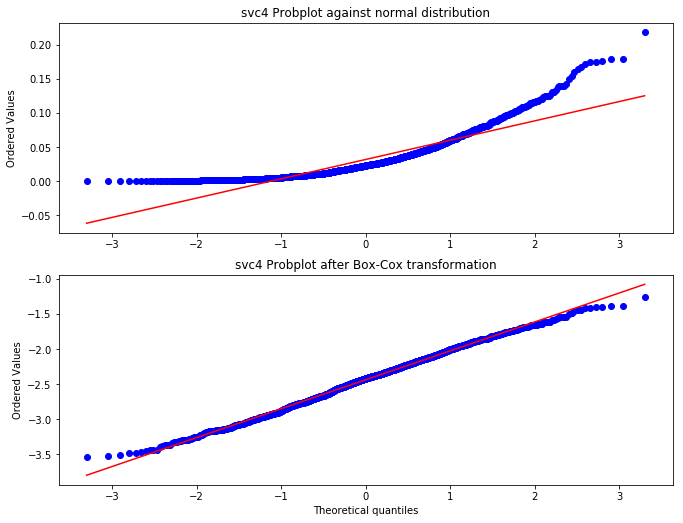

In [120]:
## Perform Box-Cox transformation for each service:
subsets = {}
svcs.sort()
for ii in range(len(svcs)):

    ## Extract the service's data; execute the Box-Cox transformation
    subset = mydfLong[mydfLong['service'] == svcs[ii]].copy()
    x = subset['resp_time']
    xt, lmbda = stats.boxcox(x)
    subset['boxcox_rt'] = xt
    
    plot_pre_post_bctransform(x, xt, svcs[ii])
    
    print ('For %s, got Box-Cox lambda = %5.3f' %(svcs[ii], lmbda))
    subsets[svcs[ii]] = subset

mydfLongBC = pd.concat(subsets, ignore_index=True)

In [121]:
mydfLongBC.head()

,pt_num,service,resp_time,log_rt,boxcox_rt
0,0,svc1,0.273334,0.241639,-1.018291
1,1,svc1,0.574465,0.453916,-0.498563
2,2,svc1,0.257138,0.228838,-1.054713
3,3,svc1,0.322904,0.279829,-0.914392
4,4,svc1,0.379826,0.321958,-0.806479


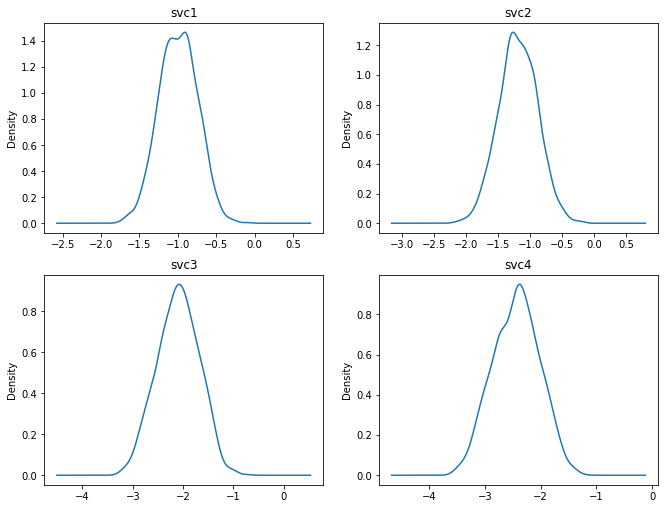

In [122]:
plot_svcs_kdes(mydfLongBC, 'boxcox_rt')

Resulting PDF plots are much more resemblant of a normal (at least symmetrical) distribution.  Now we can use [***K-Means***](https://en.wikipedia.org/wiki/K-means_clustering) clustering on the Box-Cox transformed data and match clusters to services.

##### Note: K-Means is not always a good idea.  It can be VERY misleading.  Details are in [this notebook](https://github.com/chemodan/ml_training_for_cmg_impact/blob/master/Worksheets/ipynb/ExpectationMaximizationInClustering.ipynb).

For k-means, we will use the python package called **scikit-learn** (aka sklearn).  Since we know that we have to group data into two queues, $K = 2$.

In [123]:
from sklearn.cluster import KMeans
from sklearn import metrics

## The sklearn package requires data to be in a certain shape, and because 
## we know that the time series are flat for all 4 services, we do not use 
## pt_num (timestamp) as a variable in clustering.

X = np.array(list(zip(mydfLongBC['boxcox_rt']))).reshape(len(mydfLongBC), 1)
X

array([[-1.01829146],
       [-0.49856319],
       [-1.05471342],
       ...,
       [-3.06316782],
       [-2.76057442],
       [-2.4692322 ]])

In [124]:
## Use KMeans from sklearn package to cluster the data:
K = 2
kmeans_model = KMeans(n_clusters=K).fit(X)
kmeans_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [125]:
kmeans_model.cluster_centers_
mydfLongBC['queue_id'] = list(kmeans_model.labels_)

In [126]:
## Checking the head:
mydfLongBC.head(10)

,pt_num,service,resp_time,log_rt,boxcox_rt,queue_id
0,0,svc1,0.273334,0.241639,-1.018291,0
1,1,svc1,0.574465,0.453916,-0.498563,0
2,2,svc1,0.257138,0.228838,-1.054713,0
3,3,svc1,0.322904,0.279829,-0.914392,0
4,4,svc1,0.379826,0.321958,-0.806479,0
5,5,svc1,0.217334,0.196663,-1.150632,0
6,6,svc1,0.314583,0.273519,-0.931117,0
7,7,svc1,0.253073,0.225599,-1.064074,0
8,8,svc1,0.280763,0.247456,-1.002026,0
9,9,svc1,0.244840,0.219007,-1.083316,0


In [127]:
## Checking the tail:
mydfLongBC.tail(10)

,pt_num,service,resp_time,log_rt,boxcox_rt,queue_id
5750,1430,svc4,0.013651,0.013558,-2.605792,1
5751,1431,svc4,0.027317,0.026951,-2.352738,1
5752,1432,svc4,0.044013,0.043072,-2.150779,1
5753,1433,svc4,0.045706,0.044692,-2.133728,1
5754,1434,svc4,0.021576,0.021347,-2.443878,1
5755,1435,svc4,0.019494,0.019307,-2.481423,1
5756,1436,svc4,0.085727,0.082250,-1.823842,1
5757,1437,svc4,0.002519,0.002516,-3.063168,1
5758,1438,svc4,0.008327,0.008293,-2.760574,1
5759,1439,svc4,0.020153,0.019953,-2.469232,1


Now we have **queue_id** assigned by the K-means algorithm. Because all transformations have been monotonic, cluster ID assignment based on the **boxcox_rt** column will be accurate for the **resp_time** column as well.  Then the next step is to use classification to assign services to clusters.

In [142]:
myCSV = './csvs/mydfLongBC4Classification.csv'
mydfLongBC.to_csv(myCSV, index=False)
print ('Saved the data with clusters assigned, ready for classification (%d rows) to %s' % (len(mydfLongBC), myCSV))

Saved the data with clusters assigned, ready for classification (5760 rows) to ./csvs/mydfLongBC4Classification.csv


## Classification

Some authors suggest treating regression as a special case of classification: indeed, if you have points above regression line as one category and points below as another category, then you can say that by fitting a regression line, you are solving a classification problem. 

Others say that classification is a special case of regression: we simply use discrete features (covariates, explanatory variables, independent varaibles, etc.) and use regression to get a line (known as *decision boundary*) that best separates the features.

Neither point of view is correct, even though neither is wrong.

In ML, classification is treated as a solution to a separate class of problems, where we have a bunch of independent variables (*"features"* in ML parlance) and a dependent variable taking discrete values (*"labels"*).  All classification methods match (usually linear) combinations of features to labels.

There is a wide variety of classification methods, and it is always hard to know in advance which method is approproiate for the problem at hand.  

Lately, **Deep Neural Networks** (DNN) have gained popularity, for a good reason: they do get the classificaiton right most of the time, and it is easy to train them to "just the right" predictive (generalization) power, even without understanding the specifics of how they work.  The main downside of Neural Networks has traditionally been the poor interpretability of their findings.  Until 2015, when Naftali Tishby finally came up with a [coherent theory](https://arxiv.org/abs/1503.02406) of how Deep Networks zero in on the correct label assignment: "Deep Learning and the Information Bottleneck Principle."

An alternative to DNN has been **Boosted Decision Trees,** the most commonly used ones being **Gradient-Boosted Decision Trees** (GBDT) and **Random Forest**.  In Decision Trees, the space of features is split into a sequence, such that each feature's values are split into two (or more) zones, usually in the order of their *information gain*.  E.g., if we have two features $X_1$ and $X_2$, and the information contained in $X_1$ is greater than in $X_2$, then Decision Tree will first look for the decision-boundary split on $X_1$ and then on $X_2$.  We shall explore boosting as a machine-learning technique later, after we study model-quality analysis.

Neural Networks and Decision Trees are very useful and powerful in situation where there are many features, and we do not know how to best assign the labels.  Then we let the algorithm make the decision for us.

For less complex cases, there are such methods as [**Support-Vector Machine (SVM)**](https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72), [**Naive Bayes (NB)**](http://www.statsoft.com/textbook/naive-bayes-classifier), [**K Nearest Neighbors (KNN)**](https://www.python-course.eu/k_nearest_neighbor_classifier.php), and some others.

In the scenario we are solving for, we only have one label (**queue_id**) and one categorical feature (**service**). There are no heuristic rules of thumb in ML telling us which method to use.  One way to do it is to try them all and compare based on some formal criteria, which we will talk about in the next session.

Here we will demonstrate the proper ML workflow, because classification is a great way to illustrate these ideas.


In [128]:
## 1. Feature Engineering to fit data format 
##    into the requirements of the method:

svc_ids = [float(svc.replace('svc', '')) for svc in mydfLongBC['service']]
X = np.array(list(zip(svc_ids))).reshape(len(mydfLongBC), 1)
y = list(mydfLongBC['queue_id'])

In [129]:
## 2. Split the data randomly into traning and testing subsets.  
##    We will use 25% of the data for testing our classifier
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.25)

Now we instantiate the $SVM$ model and train it.  The $\gamma$ parameter controls the bias-variance tradeoff.  We will talk about this in the next notebook.

In [130]:
## 3. Use the *_train to train the classifier and 
##    *_test to verify that the classifier does the right thing
from sklearn import svm

## 3.1 We create an instance of Support-Vector Classifier (SVC)
clf = svm.SVC(gamma=0.001)

## 3.2 We then train it using ('fit it' into) the training subset of the data
clf_model = clf.fit(X_train, y_train)  
clf_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### 4. To test the model, we use the predict() method applied to the trained classifier clf:

In [140]:
test_predict = clf.predict(X_test)

#### 4.1 Now we bring togther X_test, y_test, test_predict:

In [ ]:
testDF = pd.DataFrame({'X_test': [xx[0] for xx in X_test], 
                       'y_test': y_test, 
                       'test_predict': test_predict})

#### 4.2  Then we compare y_test with test_predict:

In [138]:
testDF['correct'] = testDF['y_test'] == testDF['test_predict']
testDF.tail(10)

,X_test,y_test,test_predict,correct
1430,2.0,1,0,False
1431,3.0,1,1,True
1432,2.0,0,0,True
1433,3.0,0,1,False
1434,1.0,0,0,True
1435,2.0,0,0,True
1436,1.0,0,0,True
1437,3.0,1,1,True
1438,2.0,0,0,True
1439,4.0,1,1,True


#### 4.3   Surely we'll have some hits and some misses.  
The percentage of hits in total is known as **classifier accuracy**:

In [137]:
print('SVM accuracy, measured on test data, is %3.2f percent' %(100.0 * sum(testDF['correct']/len(testDF))))

SVM accuracy, measured on test data, is 93.06 percent


## What have we done here?
We have built a classifier that will use the results of k-means clustering of service response times to automatically assign the service to Queue 1 or Queue 2 with $93+\%$ accuracy.  Now this classifier can be directly applied to any services that need queue assignment.

In the process, we conducted ***feature engineering*** to reshape the response-time data distribution, so that the skew would not get in the way of clustering.  In some cases, we may be able to get away with *nonparametric* (percentile-based) statistical methods to achieve results.  

We then clusted the engineered features using the K-Means technique.  We applied it to a single feature (response time), but it is expandable to multiple features.

As soon as we got the clusters defined, we classified services into clusters and measured the accuracy, which was satisfactory for the problem we solved.

### Would it work with nonstationary data?
Yes, but we will need to include the **pt_num** as a feature when clustering the data.

### Would SVM work with a different set of patterns in data?
SVM is a very powerful technique, but like all ML techniques, it has its limitations.  The scenario we have explored here is a good use case for SVM, because we have a fairly clear boundary separating response times for (svc1, svc2) from response times for (svc3, svc4).  In other use cases, we would probably require additional feature engineering (besides the Box-Cox transformation).